In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:


TICKER = "SPY"     # proxy S&P500 tradable
# TICKER = "^GSPC" # indice S&P500 (si Yahoo le laisse passer)

df = yf.download(TICKER, period="10y", interval="1d", auto_adjust=False)
df = df.dropna()

df = yf.download(TICKER, period="10y", interval="1d")

# Aplatir les colonnes si besoin
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

last_close = df["Close"].iloc[-1]
print(f"Dernier Close {TICKER}: {last_close:.2f}")


df.to_csv(f"price_{TICKER}.csv")
print("CSV écrit:", f"price_{TICKER}.csv")


[*********************100%***********************]  1 of 1 completed
C:\Users\werid\AppData\Local\Temp\ipykernel_35952\2754489814.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period="10y", interval="1d")
[*********************100%***********************]  1 of 1 completed

Dernier Close SPY: 695.49
CSV écrit: price_SPY.csv


In [3]:
df["Close"].isna().sum()

np.int64(0)

In [4]:
# Utiliser le prix ajusté (dividendes + splits)
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# Supprimer la première ligne NaN
df = df.dropna(subset=["log_return"])

In [5]:
df["log_return" ].head()

Date
2016-01-29    0.024085
2016-02-01   -0.000361
2016-02-02   -0.018187
2016-02-03    0.005977
2016-02-04    0.001567
Name: log_return, dtype: float64

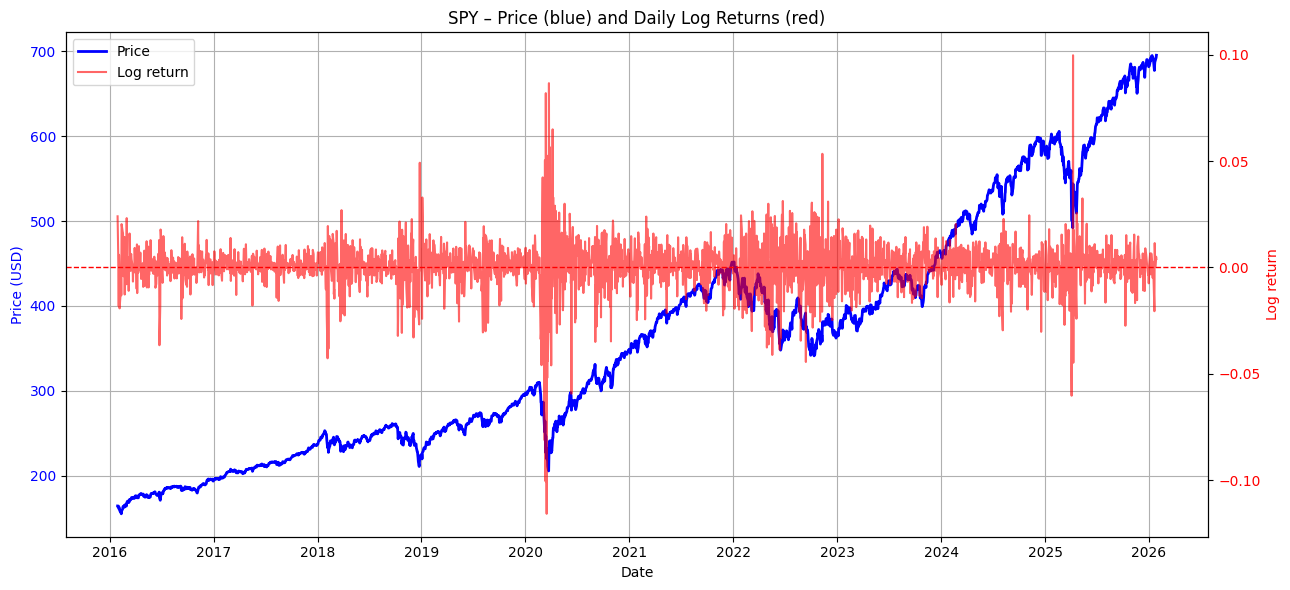

In [6]:
# Create figure
fig, ax1 = plt.subplots(figsize=(13, 6))

# 🔵 Price (LEFT axis)
ax1.plot(
    df.index,
    df["Close"],
    color="blue",
    linewidth=2,
    label="Price"
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# 🔴 Log-returns (RIGHT axis)
ax2 = ax1.twinx()
ax2.plot(
    df.index,
    df["log_return"],
    color="red",
    alpha=0.6,
    label="Log return"
)
ax2.axhline(0, color="red", linestyle="--", linewidth=1)
ax2.set_ylabel("Log return", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Legend (merge both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("SPY – Price (blue) and Daily Log Returns (red)")
plt.tight_layout()
plt.show()

In [7]:
df

Price,Close,High,Low,Open,Volume,log_return
Date,,,,,,
2016-01-29,164.185150,164.320759,160.930606,161.049260,210529300,0.024085
2016-02-01,164.125809,164.914026,162.591766,163.176570,136061600,-0.000361
2016-02-02,161.167908,162.701950,160.642425,162.693479,182564900,-0.018187
2016-02-03,162.134079,162.540894,158.574421,162.227309,205054900,0.005977
2016-02-04,162.388351,163.363015,160.998389,161.634043,139531800,0.001567
...,...,...,...,...,...,...
2026-01-21,685.400024,688.739990,678.130005,679.650024,127844500,0.011475
2026-01-22,688.979980,691.130005,686.919983,689.849976,77112200,0.005210
2026-01-23,689.229980,690.960022,687.159973,688.150024,63059600,0.000363


In [8]:
df_simple = df[["Close", "log_return"]].copy()

In [9]:
df_simple

Price,Close,log_return
Date,,
2016-01-29,164.185150,0.024085
2016-02-01,164.125809,-0.000361
2016-02-02,161.167908,-0.018187
2016-02-03,162.134079,0.005977
2016-02-04,162.388351,0.001567
...,...,...
2026-01-21,685.400024,0.011475
2026-01-22,688.979980,0.005210
2026-01-23,689.229980,0.000363


In [10]:
split_date = "2025-07-01"

train = df_simple.loc[df_simple.index < split_date]
test  = df_simple.loc[df_simple.index >= split_date]


In [11]:
test

Price,Close,log_return
Date,,
2025-07-01,614.127686,-0.000324
2025-07-02,616.911743,0.004523
2025-07-03,621.773865,0.007850
2025-07-07,617.140320,-0.007480
2025-07-08,616.802368,-0.000548
...,...,...
2026-01-21,685.400024,0.011475
2026-01-22,688.979980,0.005210
2026-01-23,689.229980,0.000363


In [12]:
test.describe()

Price,Close,log_return
count,145.000000,145.000000
mean,659.864032,0.000856
std,23.442533,0.006815
min,614.127686,-0.027400
25%,639.770569,-0.002736
50%,663.708801,0.001831
75%,680.987732,0.005065
max,695.489990,0.015484


In [13]:
train.describe()

Price,Close,log_return
count,2368.000000,2368.000000
mean,339.678009,0.000567
std,120.380539,0.011540
min,154.980896,-0.115887
25%,239.634651,-0.003595
50%,318.882797,0.000702
75%,420.685432,0.005977
max,614.326477,0.099863


C:\Users\werid\AppData\Local\Temp\ipykernel_35952\3825776825.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels)


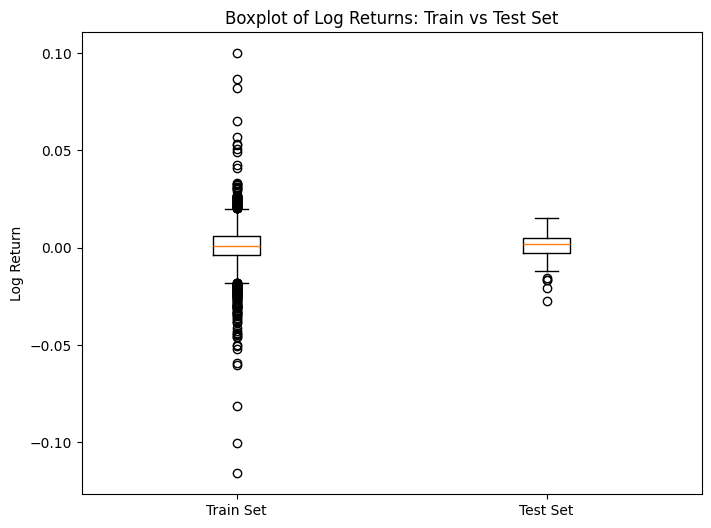

In [14]:
boxplot_data = [train["log_return"], test["log_return"]]
labels = ['Train Set', 'Test Set']
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data, labels=labels)
plt.title('Boxplot of Log Returns: Train vs Test Set')
plt.ylabel('Log Return')
plt.show()

In [15]:
import numpy as np
import pandas as pd

def detect_volatility_clusters(
    df,
    return_col="log_return",
    short_window=60,
    long_window=200,
    ratio_threshold=1.5,
    min_duration=3
):
    """
    Detect volatility clusters based on local vs long-term volatility divergence.

    Returns:
    - df with volatility measures and cluster flag
    - list of (start_date, end_date) clusters
    """
    df = df.copy()

    # Short-term and long-term volatility
    df["vol_short"] = df[return_col].rolling(short_window, center=False).std()
    df["vol_long"] = df[return_col].rolling(long_window, center=True).std()

    # Volatility ratio
    df["vol_ratio"] = df["vol_short"] / df["vol_long"]

    # Initial high-vol flag
    df["high_vol_flag"] = df["vol_ratio"] > ratio_threshold

    # ---- Extract clusters (bags) ----
    clusters = []
    start = None
    duration = 0

    for date, is_high in df["high_vol_flag"].items():
        if is_high:
            if start is None:
                start = date
                duration = 1
            else:
                duration += 1
        else:
            if start is not None and duration >= min_duration:
                clusters.append((start, date))
            start = None
            duration = 0

    # Edge case
    if start is not None and duration >= min_duration:
        clusters.append((start, df.index[-1]))

    return df, clusters
df_clusters, clusters = detect_volatility_clusters(train)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_volatility_clusters(
    df,
    price_col="Adj Close",          # ou "Close" selon ton df
    return_col="log_return",
    short_window=60,
    long_window=120,
    ratio_threshold=1.5,
    min_duration=3,
    title="Prix et périodes de forte volatilité",
    show_vol_ratio=False,           # True si tu veux afficher vol_ratio sur 2e axe
    save_path=None                  # ex: "clusters.png"
):
    """
    Plot the full time series and highlight high-volatility clusters.
    Also prints a text summary of detected periods.
    """

    # --- Detect clusters ---
    df_clusters, clusters = detect_volatility_clusters(
        df,
        return_col=return_col,
        short_window=short_window,
        long_window=long_window,
        ratio_threshold=ratio_threshold,
        min_duration=min_duration
    )

    # --- Safety checks ---
    if price_col not in df_clusters.columns:
        raise ValueError(f"'{price_col}' not found. Available columns: {list(df_clusters.columns)}")
    if not isinstance(df_clusters.index, pd.DatetimeIndex):
        # si index Date en string
        df_clusters = df_clusters.copy()
        df_clusters.index = pd.to_datetime(df_clusters.index)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(13, 6))
    ax1.plot(df_clusters.index, df_clusters[price_col], linewidth=2, label="Prix")
    ax1.set_title(title)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(price_col)
    ax1.grid(False)

    # Highlight clusters
    for i, (start, end) in enumerate(clusters, start=1):
        ax1.axvspan(start, end, alpha=0.25)  # zone colorée

    # Optional: show vol_ratio on a secondary axis
    if show_vol_ratio:
        ax2 = ax1.twinx()
        ax2.plot(df_clusters.index, df_clusters["vol_ratio"], alpha=0.6, label="vol_ratio")
        ax2.axhline(ratio_threshold, linestyle="--", linewidth=1)
        ax2.set_ylabel("vol_ratio")
        # Legend merge
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    else:
        ax1.legend(loc="upper left")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()

    # --- Text summary ---
    if len(clusters) == 0:
        print("Aucune période de forte volatilité détectée (avec ces paramètres).")
    else:
        for i, (start, end) in enumerate(clusters, start=1):
            # format propre
            s = pd.to_datetime(start).strftime("%Y-%m-%d")
            e = pd.to_datetime(end).strftime("%Y-%m-%d")
            print(f"Période de forte volatilité {i}: {s} → {e}")

    return df_clusters, clusters


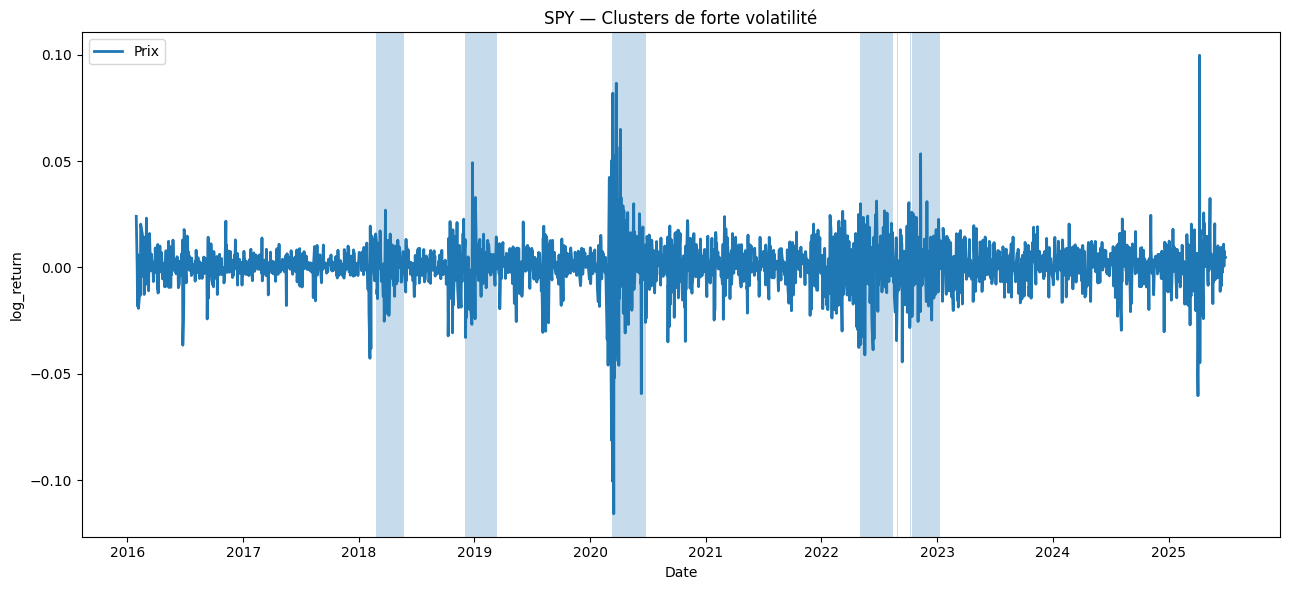

Période de forte volatilité 1: 2018-02-23 → 2018-05-22
Période de forte volatilité 2: 2018-12-03 → 2019-03-13
Période de forte volatilité 3: 2020-03-11 → 2020-06-26
Période de forte volatilité 4: 2022-05-04 → 2022-08-15
Période de forte volatilité 5: 2022-08-26 → 2022-09-01
Période de forte volatilité 6: 2022-10-07 → 2022-10-12
Période de forte volatilité 7: 2022-10-14 → 2023-01-04
Période de forte volatilité 8: 2023-01-05 → 2023-01-10


In [17]:
df_clusters, clusters = plot_volatility_clusters(
    train,
    price_col="log_return",     # ou "Close" selon ton df
    short_window=60,
    long_window=500,
    ratio_threshold=1.2,
    min_duration=3,
    show_vol_ratio=False,       # si tu veux visualiser le ratio + seuil
    title="SPY — Clusters de forte volatilité"
)


In [19]:
split_date1 = "2020-06-27"
split_date2 = "2022-05-03"
split_date3 = "2022-08-15"

train = df_simple.loc[
    (df_simple.index >= split_date1) &
    (df_simple.index <= split_date2)
]

test = df_simple.loc[
    (df_simple.index > split_date2) &
    (df_simple.index <= split_date3)
]

In [21]:
train.describe()

Price,Close,log_return
count,466.000000,466.000000
mean,380.712351,0.000756
std,46.090631,0.010111
min,281.871521,-0.037656
25%,343.085243,-0.004516
50%,393.158890,0.001458
75%,418.380844,0.007367
max,451.875153,0.026458


Calcul de la VAR non paramétrique

In [22]:
def var_historique_1j(log_returns, alpha=0.99):
    """
    VaR historique à 1 jour au niveau alpha à partir de log-rendements.
    
    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements (r_t).
    alpha : float
        Niveau de confiance (ex: 0.99 pour VaR 99%).

    Retour
    ------
    float
        VaR (positive), i.e. perte telle que P(L <= VaR) = alpha avec L = -r.
    """
    r = pd.Series(log_returns).dropna()

    # Quantile de la queue gauche des rendements
    q = np.quantile(r, 1 - alpha)

    # VaR en pertes (positive)
    return float(-q)


In [24]:
VaR_99 = var_historique_1j(train["log_return"], alpha=0.99)
print(VaR_99)

0.028370609155251303


In [25]:
import numpy as np
import pandas as pd

def var_historique_bootstrap_1j(log_returns, alpha=0.99, alpha_IC=0.95, B=2000, random_state=None):
    """
    VaR historique à 1 jour au niveau alpha + intervalle de confiance bootstrap (percentile)
    de niveau alpha_IC.

    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements r_t.
    alpha : float
        Niveau de confiance de la VaR (ex: 0.99).
    alpha_IC : float
        Niveau de confiance de l'intervalle (ex: 0.95).
    B : int
        Nombre de réplications bootstrap.
    random_state : int ou None
        Graine pour reproductibilité.

    Retour
    ------
    var_hat : float
        VaR historique (positive), avec L = -r.
    ic : tuple(float, float)
        (borne_inf, borne_sup) de l'IC bootstrap percentile.
    """
    r = pd.Series(log_returns).dropna().to_numpy()
    n = r.size
    if n < 2:
        raise ValueError("La série doit contenir au moins 2 rendements non-NaN.")

    rng = np.random.default_rng(random_state)

    # Estimateur VaR historique sur l'échantillon
    q = np.quantile(r, 1 - alpha)
    var_hat = float(-q)

    # Bootstrap
    vars_boot = np.empty(B, dtype=float)
    for b in range(B):
        sample = rng.choice(r, size=n, replace=True)
        vars_boot[b] = -np.quantile(sample, 1 - alpha)

    # IC percentile (central)
    tail = (1 - alpha_IC) / 2
    lower = float(np.quantile(vars_boot, tail))
    upper = float(np.quantile(vars_boot, 1 - tail))

    return var_hat, (lower, upper)


In [ ]:
var_99, ic_95 = var_historique_bootstrap_1j(train["log_return"], alpha=0.99, alpha_IC=0.95, B=500, random_state=42)
print("VaR 99% :", var_99)
print("IC 95% :", ic_95)

VaR 99% : 0.028370609155251303
IC 95% : (0.023256786328876483, 0.03486202543660636)


In [29]:
var_99, ic_90 = var_historique_bootstrap_1j(train["log_return"], alpha=0.99, alpha_IC=0.90, B=500, random_state=42)
print("VaR 99% :", var_99)
print("IC 90% :", ic_90)


VaR 99% : 0.028370609155251303
IC 90% : (0.02390575201586162, 0.034776578145232204)


In [30]:
def nb_exceptions(test_returns, VaR):
    """
    Compte le nombre d'exceptions associées à une VaR donnée.

    Paramètres
    ----------
    test_returns : array-like ou pd.Series
        Log-rendements de l'échantillon test.
    VaR : float
        VaR à 1 jour (positive).

    Retour
    ------
    n_exc : int
        Nombre d'exceptions.
    rate_exc : float
        Taux d'exceptions.
    """
    r_test = pd.Series(test_returns).dropna().to_numpy()

    exceptions = r_test < -VaR
    n_exc = int(exceptions.sum())
    rate_exc = n_exc / len(r_test) if len(r_test) > 0 else np.nan

    return n_exc, rate_exc


In [31]:
n_exc, rate = nb_exceptions(test["log_return"], VaR_99)

print("Nombre d'exceptions :", n_exc)
print("Taux d'exceptions   :", rate)

Nombre d'exceptions : 6
Taux d'exceptions   : 0.08450704225352113


In [33]:
import numpy as np
from scipy.stats import binomtest

k = 6
n = 71
p0 = 0.01          # attendu pour VaR 99%
alpha_IC = 0.9

# IC exact Clopper-Pearson
res = binomtest(k, n, p=p0, alternative="greater")
ci = res.proportion_ci(confidence_level=alpha_IC, method="exact")

print("Taux observé:", k/n)
print(f"IC {alpha_IC:.0%} (Clopper-Pearson): [{ci.low:.4f}, {ci.high:.4f}]")
print("p-value (trop d'exceptions):", res.pvalue)


Taux observé: 0.08450704225352113
IC 90% (Clopper-Pearson): [0.0450, 1.0000]
p-value (trop d'exceptions): 8.211993136167026e-05


👉 Le taux attendu sous une VaR 99% est 1%, et 1% n’appartient pas à cet intervalle.
➡️ Statistiquement, le taux d’exceptions observé est incompatible avec une VaR 99% bien calibrée (tu as trop d’exceptions → VaR sous-estime le risque sur le test).

Calcul de la VaR Gaussienne

In [34]:
from scipy.stats import norm

def var_gaussienne_1j(log_returns, alpha=0.99):
    """
    VaR gaussienne à 1 jour au niveau alpha.

    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements.
    alpha : float
        Niveau de confiance (ex: 0.99).

    Retour
    ------
    float
        VaR gaussienne (positive).
    """
    r = pd.Series(log_returns).dropna()

    mu = r.mean()
    sigma = r.std(ddof=1)

    z = norm.ppf(1 - alpha)

    VaR = -(mu + sigma * z)
    return float(VaR)


In [35]:
VaR_gauss_99 = var_gaussienne_1j(train["log_return"], alpha=0.99)
print(VaR_gauss_99)

0.02276542436927876


In [36]:
# Validation ex-ante

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def validation_ex_ante_gaussienne(log_returns, alpha=0.99, window_vol=20):
    """
    Validation ex-ante pour l'hypothèse gaussienne sur une série de log-rendements.
    - Série de rendements
    - Volatilité glissante (clustering)
    - Histogramme + fit normal
    - QQ-plot vs Normal(0,1) (standardisé)
    - Marque la quantile (1-alpha) théorique sous normalité (queue gauche)
    """
    r = pd.Series(log_returns).dropna()
    n = len(r)

    mu = r.mean()
    sigma = r.std(ddof=1)

    # standardisation
    z = (r - mu) / sigma

    # quantile queue gauche (rendements)
    q_emp = np.quantile(r, 1 - alpha)
    q_norm = mu + sigma * stats.norm.ppf(1 - alpha)

    # ---- 1) Rendements (time series) ----
    plt.figure(figsize=(12, 4))
    plt.plot(r.index, r.values)
    plt.axhline(q_emp, linestyle="--")
    plt.axhline(q_norm, linestyle="--")
    plt.title(f"Log-rendements (n={n}) et quantile (1-α) | α={alpha}")
    plt.xlabel("Date")
    plt.ylabel("log_return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 2) Volatilité glissante ----
    vol_roll = r.rolling(window_vol).std()
    plt.figure(figsize=(12, 4))
    plt.plot(vol_roll.index, vol_roll.values)
    plt.title(f"Volatilité glissante (std sur {window_vol} jours) — détection clustering")
    plt.xlabel("Date")
    plt.ylabel("rolling std")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 3) Histogramme + fit normal ----
    plt.figure(figsize=(8, 4.8))
    plt.hist(r.values, bins=60, density=True)

    xs = np.linspace(r.min(), r.max(), 400)
    plt.plot(xs, stats.norm.pdf(xs, loc=mu, scale=sigma))
    plt.axvline(q_emp, linestyle="--", linewidth=1)
    plt.axvline(q_norm, linestyle="--", linewidth=1)
    plt.title("Histogramme des rendements + densité normale ajustée")
    plt.xlabel("log_return")
    plt.ylabel("densité")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 4) QQ-plot (standardisé) ----
    plt.figure(figsize=(6, 6))
    stats.probplot(z.values, dist="norm", plot=plt)
    plt.title("QQ-plot des rendements standardisés vs N(0,1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 5) Statistiques simples (queue / asymétrie) ----
    skew = stats.skew(r.values, bias=False)
    kurt = stats.kurtosis(r.values, fisher=True, bias=False)  # excess kurtosis

    print(f"mu = {mu:.6f}, sigma = {sigma:.6f}")
    print(f"Quantile empirique (1-α) : {q_emp:.6f}")
    print(f"Quantile normal ajusté (1-α) : {q_norm:.6f}")
    print(f"Asymétrie (skewness) : {skew:.3f}")
    print(f"Kurtosis excédentaire : {kurt:.3f}  (0 si normal)")


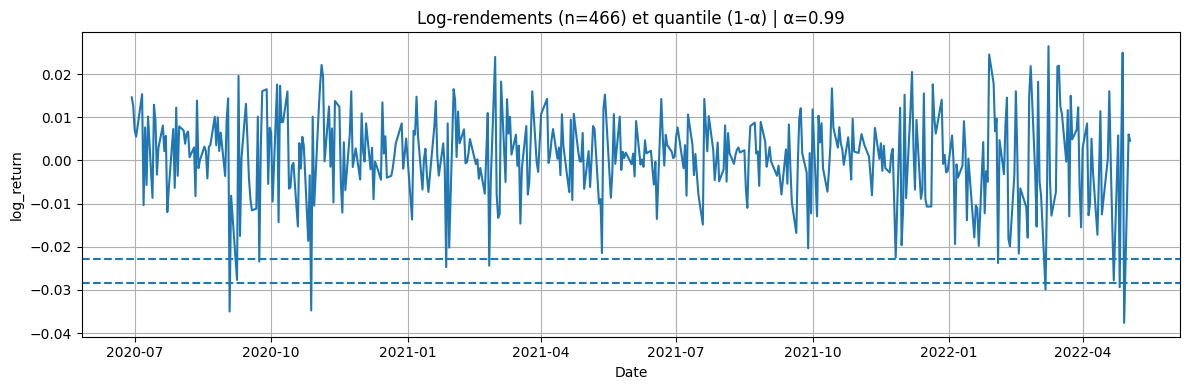

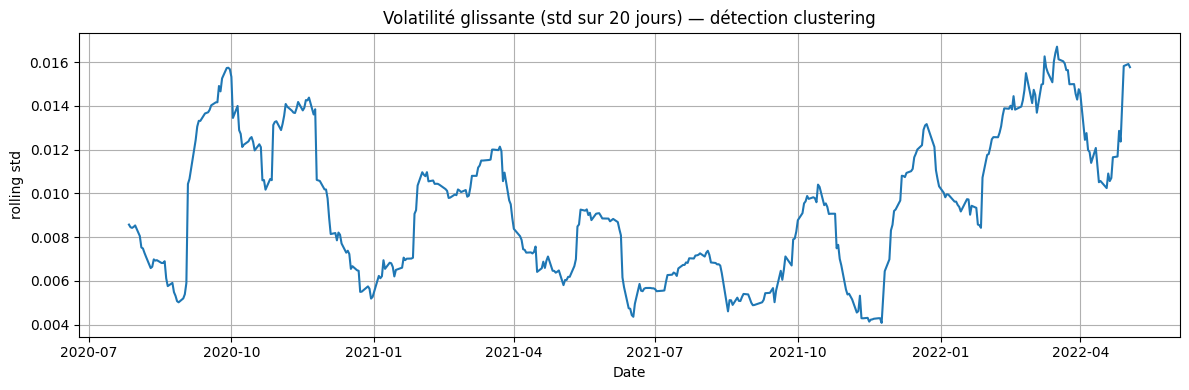

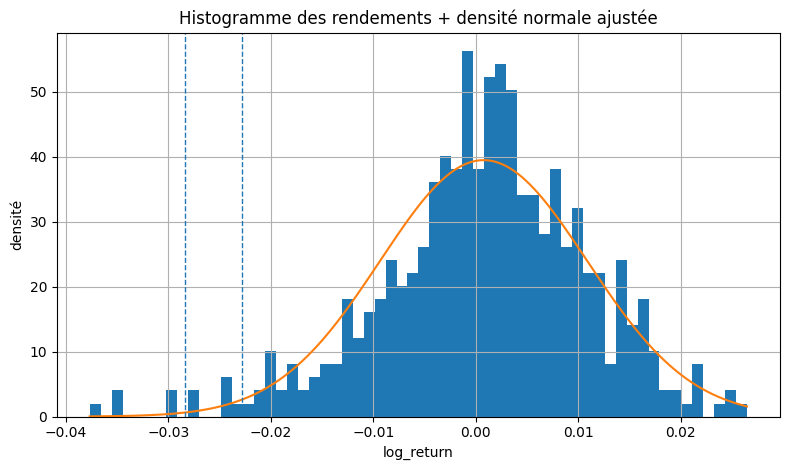

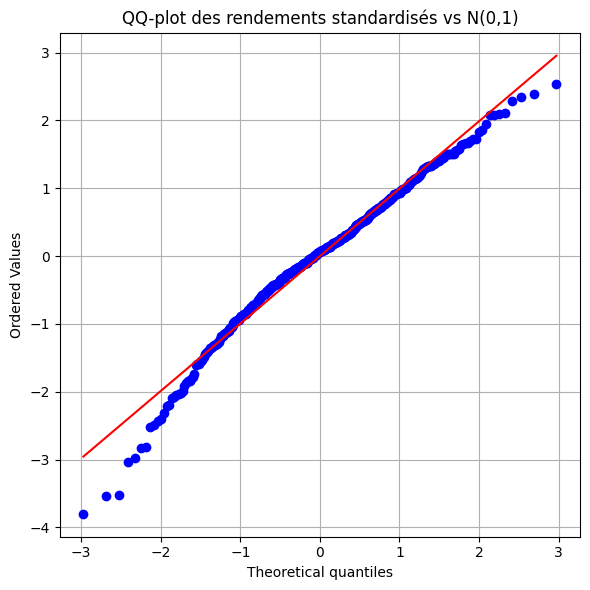

mu = 0.000756, sigma = 0.010111
Quantile empirique (1-α) : -0.028371
Quantile normal ajusté (1-α) : -0.022765
Asymétrie (skewness) : -0.541
Kurtosis excédentaire : 0.960  (0 si normal)


In [37]:
validation_ex_ante_gaussienne(train["log_return"], alpha=0.99, window_vol=20)

In [38]:
# Calcul de la VaR gaussienne à 10 jours paramètre d'échelle √10
VaR_gauss_10j = VaR_gauss_99 * np.sqrt(10)
print(VaR_gauss_10j)

0.07199059290722304


In [56]:
import numpy as np

def var_gaussienne_diffusion_10j_prix(S0, mu, sigma, alpha=0.99, n_sims=200000, seed=42):
    rng = np.random.default_rng(seed)
    T = 10  # jours
    Z = rng.standard_normal(n_sims)

    # GBM exact sur horizon T
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # perte (positive si baisse)
    loss = S0 - ST

    # VaR = quantile alpha des pertes
    return float(np.quantile(loss, alpha))
VaR_10j_99 = var_gaussienne_diffusion_10j_prix(S0, mu, sigma, alpha=0.99, n_sims=20000, seed=42)
print(VaR_10j_99)


25.863170534407534


In [58]:
import numpy as np
from scipy.stats import norm

def var_gaussienne_10j_rendement(mu, sigma, alpha=0.99):
    T = 10
    z = norm.ppf(1 - alpha)  # négatif
    return float(-(mu*T + sigma*np.sqrt(T)*z))  # VaR en % (positive)

VaR_10j_99 = var_gaussienne_10j_rendement(mu, sigma, alpha=0.99)
print(VaR_10j_99)



0.06682207749299422


In [50]:
S0 = float(train["Close"].iloc[-1])          # ou "Adj Close"
mu = float(train["log_return"].mean())
sigma = float(train["log_return"].std(ddof=1))

VaR_10j_99 = var_gaussienne_diffusion_10j(S0, mu, sigma, alpha=0.99, n_sims=20000, seed=42)
print(VaR_10j_99)


25.863170534407534


In [51]:
print("mu, sigma, S0:", mu, sigma, S0)

mu, sigma, S0: 0.0007558826108104454 0.010110829615191195 395.0854797363281
